In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import obonet
import random
import torch
import math
from Bio import SeqIO
import Bio.PDB
import urllib.request
import py3Dmol
import pylab
import pickle as pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn.models import MLP
from torch_geometric.data import Data
from torch_geometric.nn.pool import SAGPooling
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
class CFG:
    pdbfiles: str = "/home/paul/BioHack/pdbind-refined-set/"

In [3]:
def remove_hetatm(input_pdb_file, output_pdb_file):
    # Open the input PDB file for reading and the output PDB file for writing
    with open(input_pdb_file, 'r') as infile, open(output_pdb_file, 'w') as outfile:
        for line in infile:
            # Check if the line starts with 'HETATM' (non-protein atoms)
            if line.startswith('HETATM'):
                continue  # Skip this line (HETATM record)
            # Write all other lines to the output file
            outfile.write(line)
            
def get_atom_types_from_sdf(sdf_file):
    supplier = Chem.SDMolSupplier(sdf_file)
    atom_types = set()

    for mol in supplier:
        if mol is not None:
            atoms = mol.GetAtoms()
            atom_types.update([atom.GetSymbol() for atom in atoms])

    return sorted(list(atom_types))

def get_atom_types_from_mol2_split(mol2_file):
    atom_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atom_types.add(atom_type)
    
    atom_types_split = set()
    for atom in atom_types:
        atom_types_split.add(str(atom).split('.')[0])
        

    return sorted(list(atom_types_split))

def get_atom_types_from_mol2(mol2_file):
    atom_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atom_types.add(atom_type)

    return sorted(list(atom_types))

def get_atom_list_from_mol2_split(mol2_file):
    atoms = []
    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atoms.append(atom_type)
    
    atom_list = []
    for atom in atoms:
        atom_list.append(str(atom).split('.')[0])
        

    return atom_list

def get_atom_list_from_mol2(mol2_file):
    atoms = []
    with open(mol2_file, 'r') as mol2:
        reading_atoms = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>ATOM':
                reading_atoms = True
                continue
            elif line.strip() == '@<TRIPOS>BOND':
                break

            if reading_atoms:
                parts = line.split()
                if len(parts) >= 5:
                    atom_type = parts[5]
                    atoms.append(atom_type)

    return atoms

def get_bond_types_from_mol2(mol2_file):
    bond_types = set()

    with open(mol2_file, 'r') as mol2:
        reading_bonds = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>BOND':
                reading_bonds = True
                continue
            elif reading_bonds and line.strip().startswith('@<TRIPOS>'):
                break

            if reading_bonds:
                parts = line.split()
                if len(parts) >= 4:
                    bond_type = parts[3]
                    bond_types.add(bond_type)

    return sorted(list(bond_types))

def read_mol2_bonds(mol2_file):
    bonds = []
    bond_types = []

    with open(mol2_file, 'r') as mol2:
        reading_bonds = False
        for line in mol2:
            if line.strip() == '@<TRIPOS>BOND':
                reading_bonds = True
                continue
            elif reading_bonds and line.strip().startswith('@<TRIPOS>'):
                break

            if reading_bonds:
                parts = line.split()
                if len(parts) >= 4:
                    atom1_index = int(parts[1])
                    atom2_index = int(parts[2])
                    bond_type = parts[3]
                    bonds.append((atom1_index, atom2_index))
                    bond_types.append(bond_type)

    return bonds, bond_types

def calc_residue_dist(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    return answer

def calc_contact_map(uniID,map_distance):
    pdb_code = uniID
    pdb_filename = uniID+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.pdbfiles +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    flag1 = 0
    flag2 = 0
    idx = 0
    index = []
    chain_info = []
    
    for chain1 in model:
        for resi in chain1:
            index.append(idx)
            idx += 1
            chain_info.append([chain1.id,resi.id])
        for chain2 in model:
            if flag1 == 0:
                dist_matrix = calc_dist_matrix(model[chain1.id], model[chain2.id])
            else:
                new_matrix = calc_dist_matrix(model[chain1.id], model[chain2.id])
                dist_matrix = np.hstack((dist_matrix,new_matrix))
            flag1 += 1
        flag1 = 0
        if flag2 == 0:
            top_matrix = dist_matrix
        else:
            top_matrix = np.vstack((top_matrix,dist_matrix))
        flag2 += 1
    
    contact_map = top_matrix < map_distance
    return contact_map, index, chain_info


def one_hot_encode_single_res(res):
    allowed = set("GAVCPLIMWFKRHSTYNQDEUO")
    if not set(res).issubset(allowed):
        invalid = set(res) - allowed
        raise ValueError(f"Sequence has broken AA: {invalid}")
        
    AA_dict = {'GLY':torch.Tensor([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'ALA':torch.Tensor([0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'VAL':torch.Tensor([0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'CYS':torch.Tensor([0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'PRO':torch.Tensor([0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'LEU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'ILE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'MET':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'TRP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'PHE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'LYS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'ARG':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'HIS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'SER':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'THR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]),
               'TYR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]),
               'ASN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]),
               'GLN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0]),
               'ASP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]),
               'GLU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]),}
    return AA_dict[res]

AA_dictionary = {'GLY':torch.Tensor([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'ALA':torch.Tensor([0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'VAL':torch.Tensor([0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'CYS':torch.Tensor([0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'PRO':torch.Tensor([0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'LEU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'ILE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'MET':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'TRP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'PHE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'LYS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'ARG':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'HIS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'SER':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0]),
            'THR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]),
            'TYR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]),
            'ASN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]),
            'GLN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0]),
            'ASP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]),
            'GLU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]),}

def uniID2graph(uniID,map_distance):
    atom_name = 'CA'
    node_feature = []
    edge_index = []
    edge_attr = []
    contact_map, index, chain_info = calc_contact_map(uniID,map_distance)
    pdb_code = uniID
    pdb_filename = uniID+"_pocket_clean.pdb"
    structure = Bio.PDB.PDBParser(QUIET = True).get_structure(pdb_code, (CFG.pdbfiles +'/'+pdb_code+'/'+pdb_filename))
    model = structure[0]
    
    for i in index:
        node_feature.append(one_hot_encode_single_res(model[chain_info[i][0]][chain_info[i][1]].get_resname()))
        for j in index:
            if contact_map[i,j] == 1:
                edge_index.append([i,j])
                diff_vector = model[chain_info[i][0]][chain_info[i][1]]['CA'].coord - model[chain_info[j][0]][chain_info[j][1]]['CA'].coord
                edge_feature = (np.sqrt(np.sum(diff_vector * diff_vector))/map_distance)        
                edge_attr.append(edge_feature)
                            
    edge_index = np.array(edge_index)
    edge_index = edge_index.transpose()
    edge_index = torch.Tensor(edge_index)
    edge_index = edge_index.to(torch.int64)
    edge_attr = torch.Tensor(edge_attr)
    node_feature = torch.stack(node_feature)
    graph = Data(x = node_feature, edge_index = edge_index,edge_attr = edge_attr)
    return graph

In [4]:
with open('bond_type_dict.pkl', 'rb') as f:
    bond_type_dict = pickle.load(f)

In [7]:
Embeddings = []
for i in bond_type_dict:
    Embeddings.append(torch.Tensor(bond_type_dict[i]))

In [8]:
functions_tensor = torch.stack(Embeddings)
dataset = TensorDataset(functions_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoded_size, num_layers=1, num_heads=1, hidden_size=10):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder_embedding = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.encoder_fc = nn.Linear(hidden_size, encoded_size)
        
        # Decoder
        self.decoder_fc = nn.Linear(encoded_size, hidden_size)
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.decoder_output = nn.Linear(hidden_size, input_size)
    
    def forward(self, x):
        # Encoding
        x = self.encoder_embedding(x)
        x = self.transformer_encoder(x)
        encoded = self.encoder_fc(x)
        
        # Decoding
        x = self.decoder_fc(encoded)
        x = self.transformer_decoder(x,encoded)
        decoded = self.decoder_output(x)
        
        return decoded
    
    def encode(self,x):
        x = self.encoder_embedding(x)
        x = self.transformer_encoder(x)
        encoded = self.encoder_fc(x)
        
        return encoded
    
    def dencode(self,encoded):
        x = self.decoder_fc(encoded)
        x = self.transformer_decoder(x,encoded)
        decoded = self.decoder_output(x)
        
        return decoded

In [17]:
autoencoder = Autoencoder(input_size = 5, encoded_size=1, num_layers=6,hidden_size = 1)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = autoencoder.to(DEVICE)

# Define a loss function (e.g., Mean Squared Error) and an optimizer (e.g., Adam)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,500], gamma=0.1)

# Training loop
num_epochs = 1000  # Adjust the number of epochs as needed
lowest = 0.0015
losses = []

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
dataloader_val = DataLoader(dataset, batch_size=1, shuffle=True)

for epoch in range(num_epochs):
    total_loss = 0.0
    val_loss = 0.0

    for batch in dataloader:
        inputs = batch[0].to(DEVICE).float()
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = autoencoder(inputs)
        
        # Compute the loss
        loss = criterion(outputs, inputs)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        inputs= inputs.to('cpu')
        
        total_loss += loss.item()
        
    for batch in dataloader_val:
        with torch.no_grad():
            inputs = batch[0].to(DEVICE).float()
        
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
        
            inputs= inputs.to('cpu')
        
        val_loss += loss.item()
        
    # Print the average loss for this epoch
    avg_loss = total_loss / len(dataloader)
    avg_val_loss = val_loss / len(dataloader_val)
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} Val Loss: {avg_val_loss:.4f}')
    
    if avg_loss < 0.0015 and epoch > 750:
        if lowest > avg_loss:
            torch.save(autoencoder,('bond_autoencoder_11012023_'+str(epoch+1)))
            lowest = avg_loss
            epoch_num = epoch+1
    
    #if epoch > 100:
        #torch.save(autoencoder,('autoencoder_98var_10062023_'+str(epoch)))

print('Training complete')


Epoch [1/1000] Loss: 0.7679 Val Loss: 0.7589
Epoch [2/1000] Loss: 0.7549 Val Loss: 0.7478
Epoch [3/1000] Loss: 0.7439 Val Loss: 0.7373
Epoch [4/1000] Loss: 0.7340 Val Loss: 0.7271
Epoch [5/1000] Loss: 0.7236 Val Loss: 0.7175
Epoch [6/1000] Loss: 0.7143 Val Loss: 0.7081
Epoch [7/1000] Loss: 0.7051 Val Loss: 0.6992
Epoch [8/1000] Loss: 0.6963 Val Loss: 0.6907
Epoch [9/1000] Loss: 0.6879 Val Loss: 0.6824
Epoch [10/1000] Loss: 0.6795 Val Loss: 0.6745
Epoch [11/1000] Loss: 0.6715 Val Loss: 0.6669
Epoch [12/1000] Loss: 0.6643 Val Loss: 0.6595
Epoch [13/1000] Loss: 0.6572 Val Loss: 0.6525
Epoch [14/1000] Loss: 0.6502 Val Loss: 0.6458
Epoch [15/1000] Loss: 0.6437 Val Loss: 0.6392
Epoch [16/1000] Loss: 0.6372 Val Loss: 0.6330
Epoch [17/1000] Loss: 0.6309 Val Loss: 0.6271
Epoch [18/1000] Loss: 0.6253 Val Loss: 0.6211
Epoch [19/1000] Loss: 0.6194 Val Loss: 0.6151
Epoch [20/1000] Loss: 0.6135 Val Loss: 0.6092
Epoch [21/1000] Loss: 0.6075 Val Loss: 0.6033
Epoch [22/1000] Loss: 0.6013 Val Loss: 0.59

Epoch [179/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [180/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [181/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [182/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [183/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [184/1000] Loss: 0.5014 Val Loss: 0.5004
Epoch [185/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [186/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [187/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [188/1000] Loss: 0.5009 Val Loss: 0.5004
Epoch [189/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [190/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [191/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [192/1000] Loss: 0.5013 Val Loss: 0.5004
Epoch [193/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [194/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [195/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [196/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [197/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [198/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [199/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [200/10

Epoch [355/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [356/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [357/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [358/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [359/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [360/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [361/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [362/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [363/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [364/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [365/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [366/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [367/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [368/1000] Loss: 0.5014 Val Loss: 0.5004
Epoch [369/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [370/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [371/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [372/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [373/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [374/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [375/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [376/10

Epoch [531/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [532/1000] Loss: 0.5014 Val Loss: 0.5004
Epoch [533/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [534/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [535/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [536/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [537/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [538/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [539/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [540/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [541/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [542/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [543/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [544/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [545/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [546/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [547/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [548/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [549/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [550/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [551/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [552/10

Epoch [707/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [708/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [709/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [710/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [711/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [712/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [713/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [714/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [715/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [716/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [717/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [718/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [719/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [720/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [721/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [722/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [723/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [724/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [725/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [726/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [727/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [728/10

Epoch [883/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [884/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [885/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [886/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [887/1000] Loss: 0.5009 Val Loss: 0.5004
Epoch [888/1000] Loss: 0.5014 Val Loss: 0.5004
Epoch [889/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [890/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [891/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [892/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [893/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [894/1000] Loss: 0.5013 Val Loss: 0.5004
Epoch [895/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [896/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [897/1000] Loss: 0.5009 Val Loss: 0.5004
Epoch [898/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [899/1000] Loss: 0.5011 Val Loss: 0.5004
Epoch [900/1000] Loss: 0.5013 Val Loss: 0.5004
Epoch [901/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [902/1000] Loss: 0.5010 Val Loss: 0.5004
Epoch [903/1000] Loss: 0.5012 Val Loss: 0.5004
Epoch [904/10

KeyboardInterrupt: 

In [92]:
autoencoder = torch.load('AA_atom_autoencoder_11012023')

In [14]:
sigmoid = nn.Sigmoid()

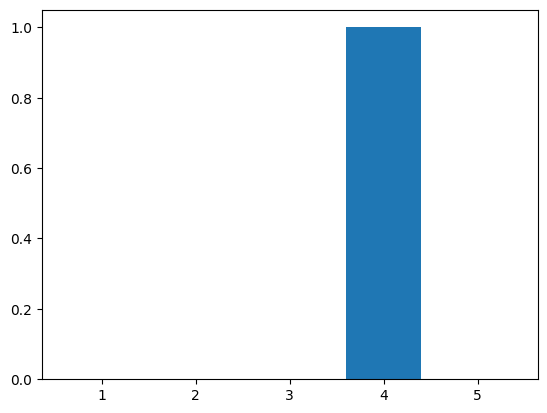

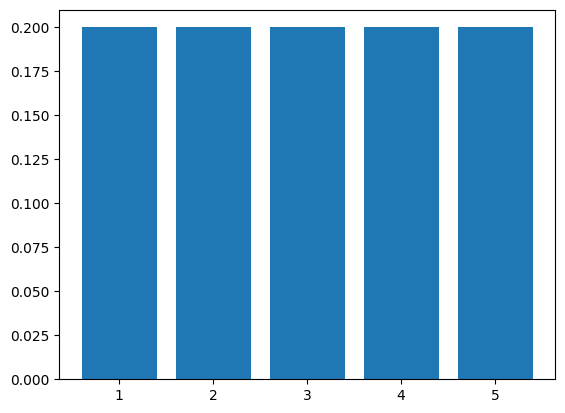

In [15]:
func = random.choice(Embeddings).unsqueeze(0).to(DEVICE)
pred = sigmoid(autoencoder(func.float()))


func = random.choice(Embeddings).unsqueeze(0).to(DEVICE)
pred = sigmoid(autoencoder(func.float()))

x_axis = np.linspace(1,5,5)

plt.bar(x_axis,func.squeeze().to('cpu').numpy())
plt.show()

plt.bar(x_axis,pred.squeeze().to('cpu').detach().numpy())
plt.show()